In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import flow_pop.cy_particles as fp

In [5]:
%load_ext cython

In [17]:
%%timeit
x = 0
for i in range(10**6):
    x += 1

10 loops, best of 3: 33.8 ms per loop


In [41]:
%%cython -a -lgsl

from cython_gsl cimport *

cpdef void do_loop() nogil:
    cdef gsl_rng *r = gsl_rng_alloc(gsl_rng_mt19937)
    
    cdef double x = 0
    cdef int i
    for i in range(10**7):
        x += gsl_ran_gaussian(r, 1.0)
    gsl_rng_free(r)

In [42]:
%%time

do_loop()

CPU times: user 531 ms, sys: 0 ns, total: 531 ms
Wall time: 532 ms


In [43]:
%%time

x = 0
for i in range(10**7):
    x += np.random.randn()

CPU times: user 2.2 s, sys: 15.8 ms, total: 2.21 s
Wall time: 2.21 s


In [45]:
%%time

x = np.random.randn(10**7).sum()

CPU times: user 367 ms, sys: 0 ns, total: 367 ms
Wall time: 366 ms


In [5]:
Lx = 150
Ly = 150
z = 1

N = 2. # Density of particles per area, physical units
droplet_density=10.

R = 4

time_prefactor = .5

mu_c = 1.0
mu_list = np.array([1.0, 1.0], dtype=np.float32)

Dc = 1.0
D_list = np.array([.1, .1], dtype=np.float32)

D_nutrient = 1.

#seed = np.random.randint(0, 2**32 - 1)
seed = 0

In [18]:
sim = fp.Simulation_2d(Lx=Lx, Ly=Ly, z=z,
                       N=N, droplet_density=droplet_density,
                       R=R, time_prefactor=time_prefactor,
                      mu_c=mu_c, mu_list=mu_list,
                      Dc=Dc, D_list=D_list,
                      D_nutrient=D_nutrient,
                      seed = seed)

Lc (effective deme size, physical units): 2.0
Tc (characteristic time scale, physical units): 1.0
dim_Di: [ 0.025  0.025]
dim_D_nutrient: 0.25
dim_Gi: [ 1.  1.]
dim_Dgi: [ 0.125  0.125]
Microscopic Gi: [ 2.  2.]
Time step (to resolve microscopic reaction rates): 0.25
Total number of nutrients: 45000
Number of particles in initial droplet: 31


In [7]:
sim.run(300)

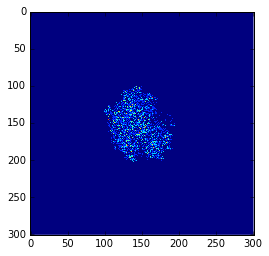

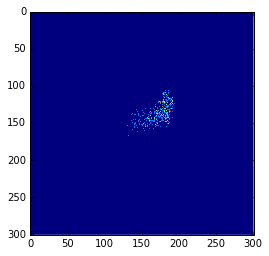

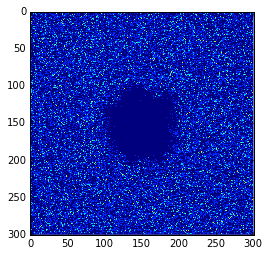

In [8]:
plt.imshow(sim.grid[:, :, 0], interpolation='None')
plt.figure()
plt.imshow(sim.grid[:, :, 1], interpolation='None')
plt.figure()
plt.imshow(sim.grid[:, :, 2], interpolation='None')

In [9]:
num_particles = len(sim.particle_dict)
pos_type = []
for cur_particle in sim.particle_dict.values():
    pos_type.append([cur_particle.x, cur_particle.y, cur_particle.pop_type])
pos_type = np.array(pos_type)

In [10]:
num_types = 3

In [11]:
color_list = ['red', 'green', 'blue']
alpha_list = [.6, .6, 0.1]

(0, 75.0)

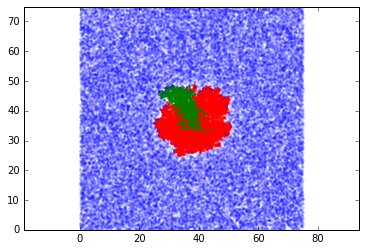

In [12]:
for i in range(num_types):
    desired_type = pos_type[pos_type[:, 2] == i]
    plt.scatter(desired_type[:, 0], desired_type[:, 1], color=color_list[i], alpha=alpha_list[i],
               s=3)

plt.axis('equal')
plt.xlim(0, sim.dim_Lx)
plt.ylim(0, sim.dim_Ly)

Well, there we go. It definitely works! :)

In [23]:
len(sim.particle_dict.values())

46780

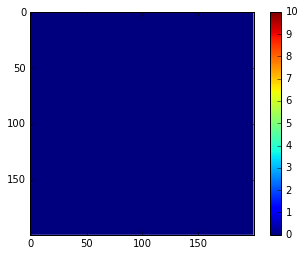

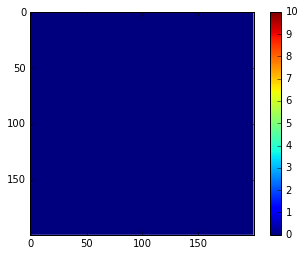

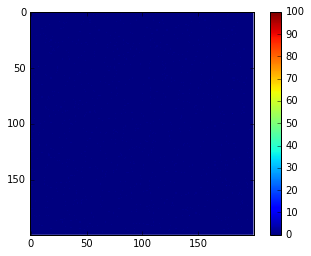

In [71]:
plt.imshow(sim.grid[:, :, 0], interpolation='None')
plt.clim(0, 10)
plt.colorbar()
plt.figure()
plt.imshow(sim.grid[:, :, 1], interpolation='None')
plt.clim(0, 10)
plt.colorbar()
plt.figure()
plt.imshow(sim.grid[:, :, 2], interpolation='None')
plt.clim(0, 100)
plt.colorbar()

Yep, this looks about right. Good. Can this be put on a GPU? It is pretty trivial to cythonize.